kaggle.json file

Steps, Go to your Kaggle Account >  Click on profile > Click on Account > Click on Create API Token

Upload your downloaded kaggle.json file in google colab environment

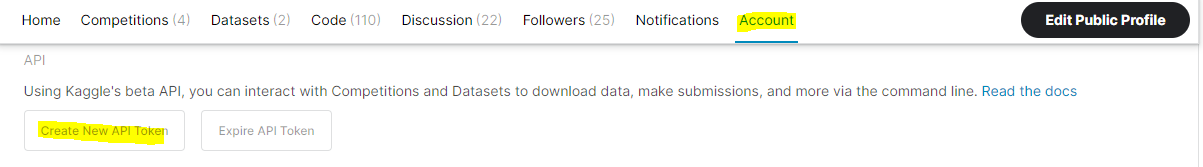

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d kazanova/sentiment140
!unzip /content/sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 96% 78.0M/80.9M [00:00<00:00, 295MB/s]
100% 80.9M/80.9M [00:00<00:00, 272MB/s]
Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


# Dataset Loading

After loading dataset columns are renamed for our reference than unneccessary columns are removed, as test and its corresponding sentiment is enough to classify each text into sentiment and then sentimentes are leblled for our reference.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [ ]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df.drop(['id', 'date', 'query','user_id'], axis = 1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Unique values in column 'sentiment'
print(df['sentiment'].unique())

[0 4]


In [ ]:
# Map 0-negative, 4-positive
df['sentiment'] = df['sentiment'].map({0: 'negative', 4: 'positive'})
print(df)

        sentiment                                               text
0        negative  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1        negative  is upset that he can't update his Facebook by ...
2        negative  @Kenichan I dived many times for the ball. Man...
3        negative    my whole body feels itchy and like its on fire 
4        negative  @nationwideclass no, it's not behaving at all....
...           ...                                                ...
1599995  positive  Just woke up. Having no school is the best fee...
1599996  positive  TheWDB.com - Very cool to hear old Walt interv...
1599997  positive  Are you ready for your MoJo Makeover? Ask me f...
1599998  positive  Happy 38th Birthday to my boo of alll time!!! ...
1599999  positive  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


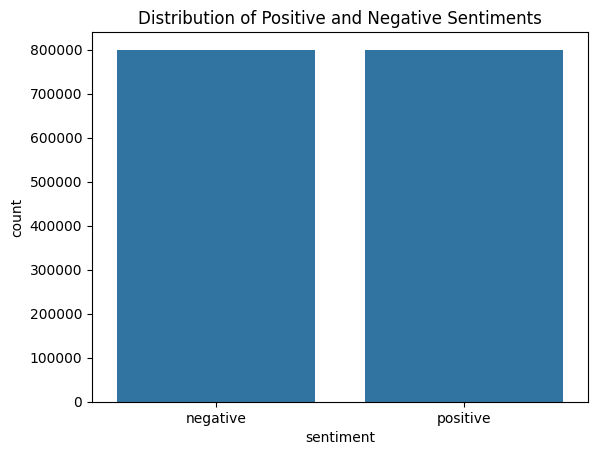

In [ ]:
# Distribution of positive and negative sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Positive and Negative Sentiments')
plt.show()


# **Preprocessing**

Dataset contains noise(mentions, urls, punctuations, stopwords) that do not add any value while model training, so those noise are removed from dataset so that model can focus on relevant features.

In [ ]:
# Removing URLs, Mentions and Websites
def remove_url_mention(text):
    # Define regex patterns
    url_pattern = r'https?://\S+|www\.\S+'
    mention_pattern = r'@\w+'
    site_pattern = r'\b\w+\.com\b'

    # Remove URLs, mentions, websites
    text = re.sub(url_pattern, '', text)
    text = re.sub(mention_pattern, '', text)
    text = re.sub(site_pattern, '', text)

    return text.strip()

df['wo_url'] = df['text'].apply(lambda text: remove_url_mention(text))


In [ ]:
# Remove Punctuations
translator = str.maketrans('', '', string.punctuation)

df['wo_punc'] = df['wo_url'].apply(lambda text: text.translate(translator))


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df["wo_stop"] = df["wo_punc"].apply(lambda text: remove_stopwords(text))

Stemming is performed to reduce words to their base or root form, which helps in normalizing text data. This ensures that words like "running," "runner," and "ran" are all treated as the same word ("run"), reducing vocabulary size and making the model more efficient by focusing on the core meaning rather than different word forms.

Also Lemmatization can be performed, which reduces word to dictionary form. Unlike stemming, which simply cuts off word endings, lemmatization considers the context and meaning of words, ensuring that different forms of a word (like "am," "are," "is") are all converted to their base form ("be").

Lemmatization is more accurate but is more time consuming, so here working with large dataset I preffered Stemming.

In [ ]:
# Apply Stemming
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["cleaned_text"] = df["wo_stop"].apply(lambda text: stem_words(text))
print(df)

        sentiment                                               text  \
0        negative  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1        negative  is upset that he can't update his Facebook by ...   
2        negative  @Kenichan I dived many times for the ball. Man...   
3        negative    my whole body feels itchy and like its on fire    
4        negative  @nationwideclass no, it's not behaving at all....   
...           ...                                                ...   
1599995  positive  Just woke up. Having no school is the best fee...   
1599996  positive  TheWDB.com - Very cool to hear old Walt interv...   
1599997  positive  Are you ready for your MoJo Makeover? Ask me f...   
1599998  positive  Happy 38th Birthday to my boo of alll time!!! ...   
1599999  positive  happy #charitytuesday @theNSPCC @SparksCharity...   

                                                    wo_url  \
0        - Awww, that's a bummer.  You shoulda got Davi...   
1        is

Dataset is very huge, so it requires high computing power and so much time. So here I have used only 20% of dataset to train a model.

In [ ]:
# Using Only 20% of Dataset
df_sampled = df.sample(frac=0.2, random_state=42)
X = df_sampled['cleaned_text']
y = df_sampled['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(256000,)
(64000,)


Vectorization is implemented to convert text data into numerical format, which is necessary for machine learning models to process and learn from textual information. In NLP, text data is often converted into vectors of numbers representing words, phrases, or entire documents.

TF-IDF vectorization converts text into vectors that reflect the importance of words in the text relative to the entire dataset.

In [ ]:
# Vectorization
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

vocab_size = len(vectorizer.vocabulary_)
print(f'Vocabulary Size: {vocab_size}')


Vocabulary Size: 106574


# Random Forest Classifier


Random forest is ensemble learning method that constructs multiple decision trees that is takes significantly more time than other method. So I have traind Random Forest with 20 decision trees on 20% of original dataset

In [ ]:
# Model training
model = RandomForestClassifier(n_estimators=20)
history = model.fit(X_train_vec, y_train)

In [ ]:
# Model evaluation
y_pred = model.predict(X_test_vec)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.75353125
              precision    recall  f1-score   support

    negative       0.74      0.79      0.76     31912
    positive       0.77      0.72      0.75     32088

    accuracy                           0.75     64000
   macro avg       0.75      0.75      0.75     64000
weighted avg       0.75      0.75      0.75     64000



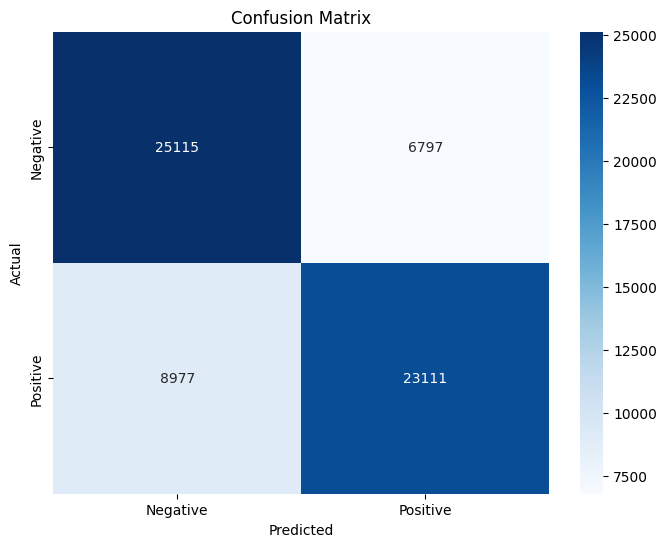

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Naive Byes


Naive Bayes is a probabilistic classifier that is much simpler and faster because it makes strong independence assumptions between features. So I have trained NB with whole dataset.

In [ ]:
# Split dataset and vectorize features
X_nb = df['cleaned_text']
y_nb = df['sentiment']

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, test_size=0.2, random_state=42)

vectorizer_nb = TfidfVectorizer()
X_train_vec_nb = vectorizer.fit_transform(X_train_nb)
X_test_vec_nb = vectorizer.transform(X_test_nb)

# Model Training
model = MultinomialNB()
model.fit(X_train_vec_nb, y_train_nb)

In [ ]:
# Model evaluation
y_pred_nb = model.predict(X_test_vec_nb)
print(f'Accuracy: {accuracy_score(y_test_nb, y_pred_nb)}')
print(classification_report(y_test_nb, y_pred_nb))

Accuracy: 0.761696875
              precision    recall  f1-score   support

    negative       0.75      0.78      0.77    159494
    positive       0.77      0.74      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



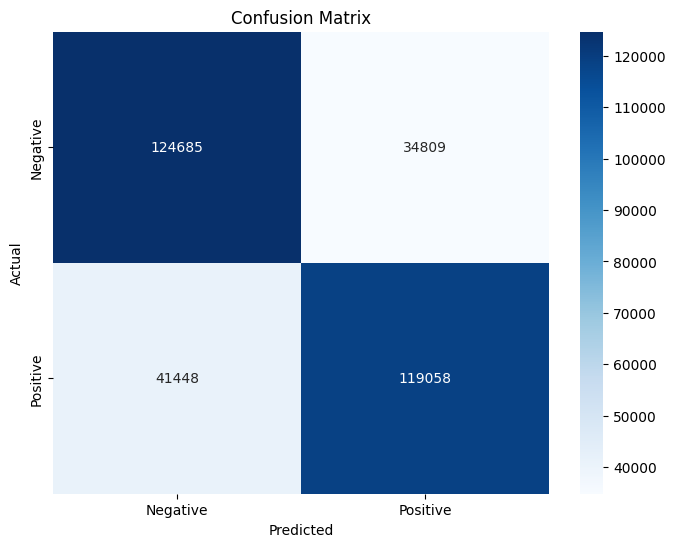

In [ ]:
cm = confusion_matrix(y_test_nb, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Based on performance matrices(accuracy, precision, recall, F1-score), perfomance of both methods are still same despite of training Random Forest on 20% of dataset.